In [1]:
import pysocialforce as psf
import numpy as np

In [2]:
# n people; 0 is primary pedestrian, others randomly placed
def circle_random_initial_states(n):
    speed0 = 0.7 + 0.4 * np.random.rand(1)[0]
    ped0 = np.array([-5.0, 0.0, speed0, 0.0, 6.0, 0.0])
    
    initial_states = np.zeros((n, 6))
    initial_states[0, :] = ped0
    
    for i, theta in enumerate(0.25 + np.random.rand(n) * (2.0 * np.pi - 0.5)):
        # ped1 at a random angle with +/-20% speed variation
        c, s = np.cos(theta), np.sin(theta)
        r = np.array([[c, -s], [s, c]])
        ped1 = np.concatenate((
            np.matmul(r, ped0[0:2]),
            np.matmul(r, ped0[2:4] * (0.7 + 0.4 * np.random.rand(1))),
            np.matmul(r, ped0[4:6]),
        ))
        initial_states[i, :] = ped1
        
    return initial_states


# n people; 0 is primary pedestrian, others randomly placed stationary
def random_initial_states(n):
    x_lim, y_lim = 5, 5
    speed0 = 0.7 + 0.4 * np.random.rand(1)[0]
    sy, gy = np.random.uniform(-5, 5), np.random.uniform(-5, 5)
    ped0 = np.array([-5.0, sy, speed0, 0.0, 5.0, gy])
    
    initial_states = np.zeros((n, 6))
    initial_states[0, :] = ped0
    
    for i in range(1, n):
        pedx = np.random.uniform(-x_lim, x_lim)
        pedy = np.random.uniform(-y_lim, y_lim)
        
        initial_states[i] = [pedx, pedy, 0, 0, pedx, pedy]
    
    return initial_states


def generate_random_scene(n):
    # num_peds is a random number s.t. 1 <= num_peds <= n
    num_peds = np.random.randint(1, n+1)
    
    ris = random_initial_states(num_peds)
    groups = [[i] for i in range(num_peds)]
    obs = None
    
    return ris, groups, obs

In [3]:
# p0, p1: 2d x,y coords
def is_close(p0, p1, threshold=0.5):
    dist = np.sqrt((p0[0]-p1[0])**2 + (p0[1]-p1[1])**2)
    return dist<=threshold

def goal_reached():
    ped0_state = sim.get_states()[0][-1, 0]
    if is_close(initial_state[0, 4:6], ped0_state[0:2]):
        return True
    return False

MovieWriter stderr:
convert-im6.q16: cache resources exhausted `data/1655807522/images/0.gif' @ error/cache.c/OpenPixelCache/4083.
convert-im6.q16: memory allocation failed `data/1655807522/images/0.gif' @ error/quantize.c/SetGrayscaleImage/3285.



CalledProcessError: Command '['convert', '-size', '432x288', '-depth', '8', '-delay', '20.0', '-loop', '0', 'rgba:-', 'data/1655807522/images/0.gif']' returned non-zero exit status 1.

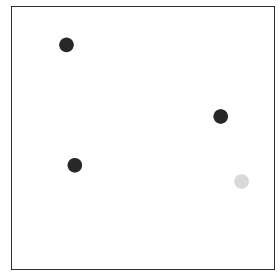

In [4]:
import os
import time
folder = str(int(time.time()))
path = f"data/{folder}/"

try:
    os.makedirs(f"{path}states")
    os.makedirs(f"{path}images")
except OSError as error:
    print(error)

nof_scenes = 10000

for i in range(nof_scenes):
    if i%10 == 0:
        print(f'Scene: {i}', end='\r')
    initial_state, grp, obs = generate_random_scene(5)
    sim = psf.Simulator(initial_state, groups=grp, obstacles=obs, config_file="config/config.toml")

    clrs = ['k' for i in grp]
    clrs[0] = 'lightgray'
    
    sim.peds.step_width = 0.01

    nof_steps = 2000
    cur_step = 0
    while cur_step < nof_steps:
        sim.step_once()
        cur_step += 1
        if goal_reached():  # wait 3 steps when goal is reached
            sim.step(3)
            break

            
    np.save(f"{path}states/{i}", sim.get_states()[0])
    
    with psf.plot.SceneVisualizer(sim, f"{path}images/{i}", agent_colors=clrs, logging=False) as sv:
        sv.ax.set_xlim(-6, 6)
        sv.ax.set_ylim(-6, 6)
        
        sv.ax.grid(False)
        sv.ax.set_xticks([])
        sv.ax.set_yticks([])
        
        sv.ax.set_xlabel('')
        sv.ax.set_ylabel('')
        
        sv.animate()

In [ ]:
# import inspect
# inspect.getfile(psf.plot)